In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/I_ForcingFiles/Initial/PrepareTS.ipynb

# Quick look at data
Load temperature and salinity measurements (dataset by M.C.)

In [2]:
ts_data = sio.loadmat('canyonTSdata.mat')
longitude = ts_data['loncanyon'][0]
latitude = ts_data['latcanyon'][0]
year = ts_data['yrcanyon'][0]
day = ts_data['daycanyon'][0]
con_temp = ts_data['tempcanyon']
abs_salt = ts_data['salcanyon']
depth = ts_data['depthcanyon']

dates = []
for i in range(len(day)):
    date = (datetime.datetime(year[i], 1, 1) + datetime.timedelta(day[i] - 1)).strftime('%b %y')
    dates.append(date)

In [3]:
xg, yg, zg = functions_plot.get_variables('G')
xn, yn, zn = functions_plot.def_regionG(-140, -136.0, 69.0, 71.0)

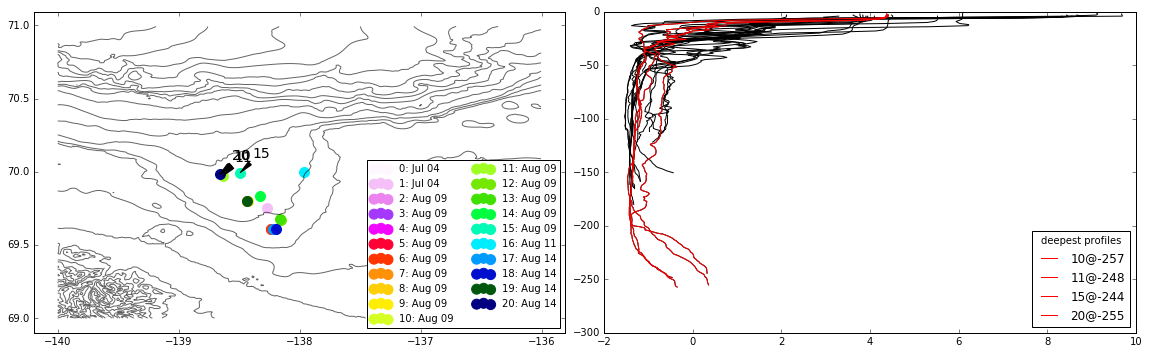

In [4]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5)); plt.tight_layout()
fig, ax1 = functions_plot.plot_region(fig, ax1, xn, yn, zn)
c = cm.gist_ncar_r(np.linspace(0, 1, len(day)))
for i in range(len(longitude)):
    ax1.scatter(longitude[i], latitude[i], color=c[i], label = str(i) + ': ' + dates[i], s=100)
ax1.legend(ncol = 2, fontsize=10, loc=4)

ax2.plot(con_temp, depth, 'k')
for j in zip([10, 11, 15, 20]): # I found the profiles deeper than -240
    ax1.annotate(str(j[0]), xy=(longitude[j], latitude[j]), 
                 xytext=(longitude[j]+0.1, latitude[j]+0.1), 
                 arrowprops=dict(facecolor='black', headwidth=4), fontsize=14)
    ax2.plot(con_temp[:,j], depth[:,j], 'r', label=str(j[0])+'@'+str(int(np.nanmin(depth[:,j]))))
ax2.legend(title='deepest profiles', loc=4)
plt.show()

# Setting the TS interpolation function

I like the 10th profile for now since it's the deepest one. Remove nans. Any extrapolation will use the last value in the profile (bounds error and fill_value).

In [10]:
profile = 10
prof_d = depth[:, profile]
prof_t = con_temp[:, profile]
prof_s = abs_salt[:, profile]
ind_end = np.where(prof_d == np.nanmin(prof_d))[0][0]
prof_depth = prof_d[:ind_end+1]
prof_ctemp = prof_t[:ind_end+1]
prof_asalt = prof_s[:ind_end+1]

In [132]:
# salishsea has default - linear. Should I make cubic?
interp_ctemp = interpolate.interp1d(prof_depth, prof_ctemp, bounds_error=False, fill_value=prof_ctemp[-1], kind='cubic')
interp_asalt = interpolate.interp1d(prof_depth, prof_asalt, bounds_error=False, fill_value=prof_asalt[-1], kind='cubic')

#  Model bathymetry profile

Grab depths from bathymetry - using idealized bathy first.

In [190]:
#grid_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/grid/grid_01.nc')
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/idealized/ideal_bathy_01.nc')
bathy = bathy_file['Bathymetry'][:]
X = bathy_file['X'][:]
Y = bathy_file['Y'][:]
bathy.shape

(87, 117)

In [189]:
bathy_file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Idealized Bathymetry Version 01
    author: Idalia A. Machuca
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/mackenzie_canyon/bathymetry/notebooks/final_bathymetry.ipynb
    description: Result of the original topo code. 87x117. Centred gaussian. No finer modifications.
    timeStamp: Thu Nov 17 14:49:15 2016
    dimensions(sizes): x(117), y(87)
    variables(dimensions): float64 X(y,x), float64 Y(y,x), float64 Bathymetry(y,x)
    groups: 

# Interpolating to data to model depths

In [134]:
size = 21
depth_levels = -1* np.linspace(bathy.min(), bathy.max(), size)
depth_levels

array([  -40.,  -103.,  -166.,  -229.,  -292.,  -355.,  -418.,  -481.,
        -544.,  -607.,  -670.,  -733.,  -796.,  -859.,  -922.,  -985.,
       -1048., -1111., -1174., -1237., -1300.])

In [208]:
votemper = np.zeros((1, len(depth_levels), bathy.shape[0], bathy.shape[1]))
votemper.shape

(1, 21, 87, 117)

In [210]:
votemper[0,0,:,:] = prof_ctemp[0]

for id in range(1, len(depth_levels)):
    for x in range(0, bathy.shape[1]):
        for y in range(0, bathy.shape[0]):
            votemper[0, id, y, x] = interp_ctemp(depth_levels[id])

votemper.shape

(1, 21, 87, 117)

In [211]:
vosaline = np.zeros((1, len(depth_levels), bathy.shape[0], bathy.shape[1]))
vosaline[0,0,:,:] = prof_asalt[0]
for id in range(1, len(depth_levels)):
    for x in range(0, bathy.shape[1]):
        for y in range(0, bathy.shape[0]):
            vosaline[0, id, y, x] = interp_asalt(depth_levels[id])

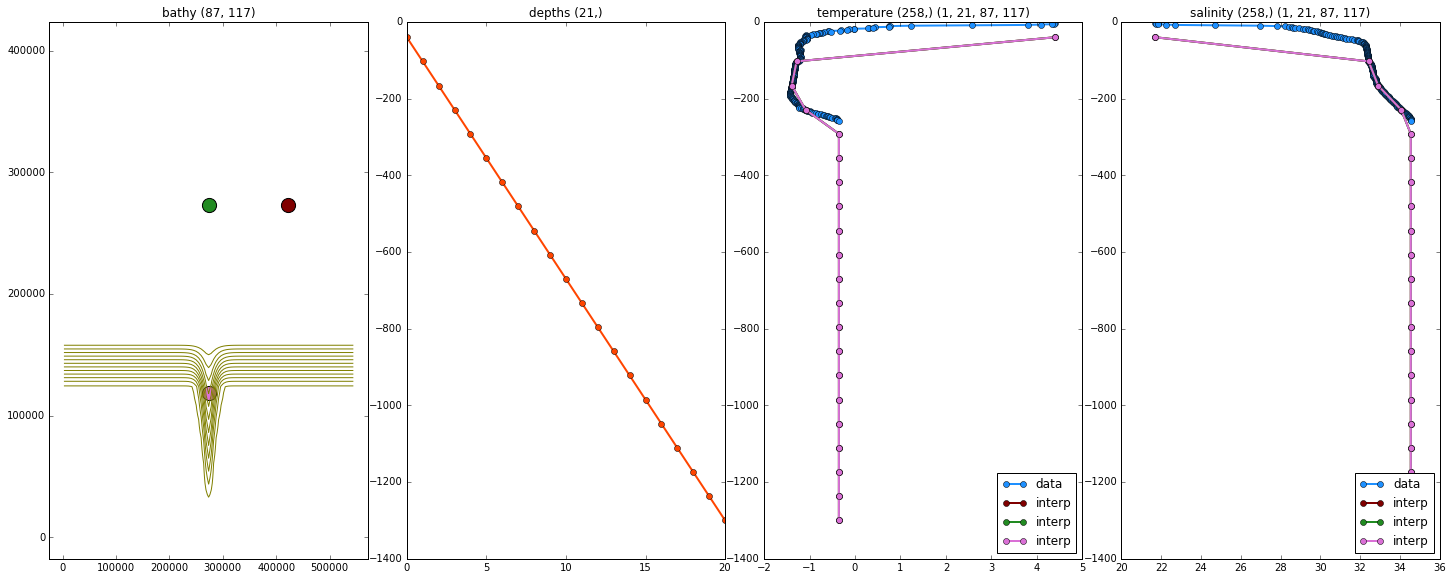

In [221]:
xs = [90, 58, 58]; ys = [58, 58, 25]; cs = ['maroon', 'ForestGreen', 'Orchid']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,8)); fig.tight_layout()
ax1.contour(X, Y, bathy, 15, linestyles='solid', colors = 'Olive', lw=2)
for yn, xn, c in zip(ys, xs, cs):
    ax1.scatter(X[yn, xn], Y[yn, xn], s=200, c=c)
ax1.set_title('bathy ' + str(bathy.shape))

ax2.plot(depth_levels, c = 'OrangeRed', lw = 2, marker = 'o', linestyle = '-')
ax2.set_title('depths ' + str(depth_levels.shape))
 
ax3.plot(prof_ctemp, prof_depth, c = 'DodgerBlue', lw=2, marker ='o', linestyle='-', label='data')
for yn, xn, c in zip(ys, xs, cs):
    ax3.plot(votemper[0, :, yn, xn], depth_levels, c=c, lw=2, marker ='o', linestyle='-', label='interp')
ax3.legend(loc=4); ax3.set_title('temperature ' + str(prof_ctemp.shape) + ' ' + str(votemper.shape))

ax4.plot(prof_asalt, prof_depth, c = 'DodgerBlue', lw=2, marker ='o', linestyle='-', label='data')
for yn, xn, c in zip(ys, xs, cs):
    ax4.plot(vosaline[0, :, yn, xn], depth_levels, c=c, lw=2, marker ='o', linestyle='-', label='interp')
ax4.legend(loc=4); ax4.set_title('salinity ' + str(prof_asalt.shape) + ' ' + str(vosaline.shape))

plt.show()